# Import Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import stdev

import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import datetime
import math
import pickle
import requests

# Define Functions

In [2]:
def Average(data):
    return sum(data) / len(data)

def convert_bit_lenght(data):        
    a = []
    for element in data:
        native_int = int(element)
        a.append(native_int.bit_length())
    return a

def normalize_series(data, mean, std):
    data = data - mean
    data = data / std
    return data

def inverse_normalize_series(data, mean, std):
    data = data * std
    data = data + mean
    return data

# Read Dataset

In [3]:
data_arrival = pd.read_excel('data-arrival_flight 1 April - 19 Juli 2023.xlsx', index_col='Unnamed: 0')
data_arrival

DATE  ARRIVAL
0    2023-04-01 00:00:00        2
1    2023-04-01 01:00:00        0
2    2023-04-01 02:00:00        0
3    2023-04-01 03:00:00        0
4    2023-04-01 04:00:00        0
...                  ...      ...
2635 2023-07-19 19:00:00       17
2636 2023-07-19 20:00:00       12
2637 2023-07-19 21:00:00        9
2638 2023-07-19 22:00:00       11
2639 2023-07-19 23:00:00        7

[2640 rows x 2 columns]

In [4]:
data_paxT3 = pd.read_excel('ready_data_pax_bms 1 April - 19 Juli 2023.xlsx', 
                        usecols=['Unnamed: 0','DATE', 'PAX_BMS_T3',],
                        index_col='Unnamed: 0')
data_paxT3

DATE  PAX_BMS_T3
0    2023-04-01 00:00:00           0
1    2023-04-01 01:00:00           0
2    2023-04-01 02:00:00           0
3    2023-04-01 03:00:00           0
4    2023-04-01 04:00:00           0
...                  ...         ...
2635 2023-07-19 19:00:00          65
2636 2023-07-19 20:00:00          90
2637 2023-07-19 21:00:00          47
2638 2023-07-19 22:00:00          31
2639 2023-07-19 23:00:00           4

[2640 rows x 2 columns]

In [5]:
frames = [data_paxT3, data_arrival['ARRIVAL']]
data = pd.concat(frames, axis=1)
data

DATE  PAX_BMS_T3  ARRIVAL
0    2023-04-01 00:00:00           0        2
1    2023-04-01 01:00:00           0        0
2    2023-04-01 02:00:00           0        0
3    2023-04-01 03:00:00           0        0
4    2023-04-01 04:00:00           0        0
...                  ...         ...      ...
2635 2023-07-19 19:00:00          65       17
2636 2023-07-19 20:00:00          90       12
2637 2023-07-19 21:00:00          47        9
2638 2023-07-19 22:00:00          31       11
2639 2023-07-19 23:00:00           4        7

[2640 rows x 3 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2640 entries, 0 to 2639
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        2640 non-null   datetime64[ns]
 1   PAX_BMS_T3  2640 non-null   int64         
 2   ARRIVAL     2640 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 82.5 KB


In [7]:
data.describe()

DATE   PAX_BMS_T3      ARRIVAL
count                 2640  2640.000000  2640.000000
mean   2023-05-25 23:30:00    57.459470     8.384091
min    2023-04-01 00:00:00     0.000000     0.000000
25%    2023-04-28 11:45:00     2.000000     2.000000
50%    2023-05-25 23:30:00    57.000000     9.000000
75%    2023-06-22 11:15:00    96.000000    13.000000
max    2023-07-19 23:00:00   227.000000    24.000000
std                    NaN    50.794938     5.894954

# Split data to training, validation and testing

split data with proportion 60% for training data, 30% for validation data and 10% for testing

In [8]:
n_lookback = 24  # length of input sequences (lookback period)
n_forecast = 24  # length of output sequences (forecast period)

In [9]:
SPLIT_TIME_TRAIN_REM = int(math.floor(0.6*((len(data))/24)) * 24) 
print(f'jumlah data training: {SPLIT_TIME_TRAIN_REM}')

jumlah data training: 1584


In [10]:
data_train = data[:SPLIT_TIME_TRAIN_REM]
data_train = pd.DataFrame(data_train)
data_train.index = data[:SPLIT_TIME_TRAIN_REM]['DATE']

data_rem = data[SPLIT_TIME_TRAIN_REM:]
data_rem = pd.DataFrame(data_rem)
data_rem.index = data[SPLIT_TIME_TRAIN_REM:]['DATE']

In [11]:
SPLIT_TIME_VAL_TEST = int(math.floor(0.77*((len(data_rem))/24)) * 24) 
SPLIT_TIME_VAL_TEST
print(f'jumlah data validation: {SPLIT_TIME_VAL_TEST}')
print(f'jumlah data validation: {len(data_rem) - SPLIT_TIME_VAL_TEST}')

jumlah data validation: 792
jumlah data validation: 264


In [12]:
data_val = data_rem[:SPLIT_TIME_VAL_TEST]
data_val = pd.DataFrame(data_val)

data_test = data_rem[SPLIT_TIME_VAL_TEST:]
data_test = pd.DataFrame(data_test)

In [13]:
# % of training set
print(f'data training -> {(len(data_train)/len(data)) * 100}%')
print(f'data validation -> {(len(data_val)/len(data)) * 100}%')
print(f'data testing -> {(len(data_test)/len(data)) * 100}%')

data training -> 60.0%
data validation -> 30.0%
data testing -> 10.0%


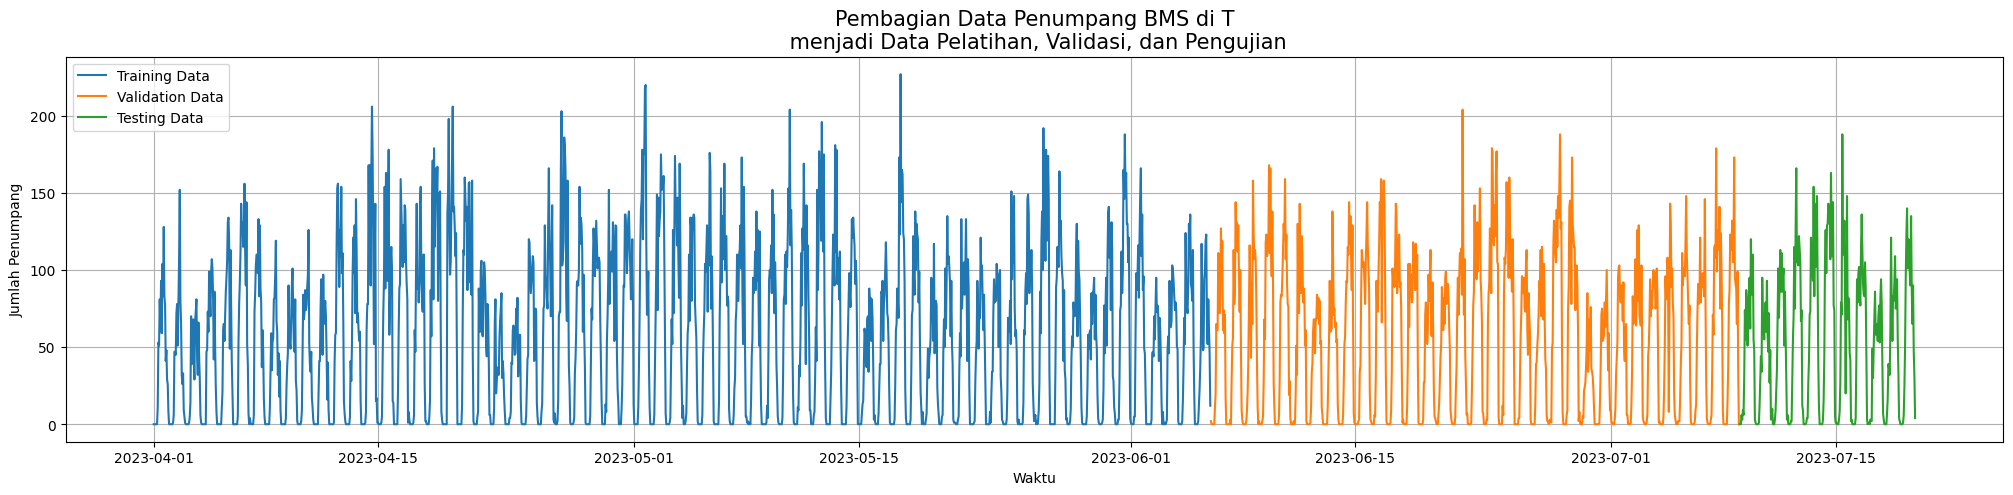

In [14]:
plt.subplots(figsize=(25, 5))
sns.lineplot(x="DATE", y="PAX_BMS_T3",
             data=data_train, label='Training Data')
sns.lineplot(x="DATE", y="PAX_BMS_T3",
             data=data_val, label='Validation Data')
sns.lineplot(x="DATE", y="PAX_BMS_T3",
             data=data_test, label='Testing Data')
plt.xlabel('Waktu'); plt.ylabel('Jumlah Penumpang')
plt.title("Pembagian Data Penumpang BMS di T\n menjadi Data Pelatihan, Validasi, dan Pengujian", fontsize = 15)
plt.grid()
plt.legend(loc='upper left')

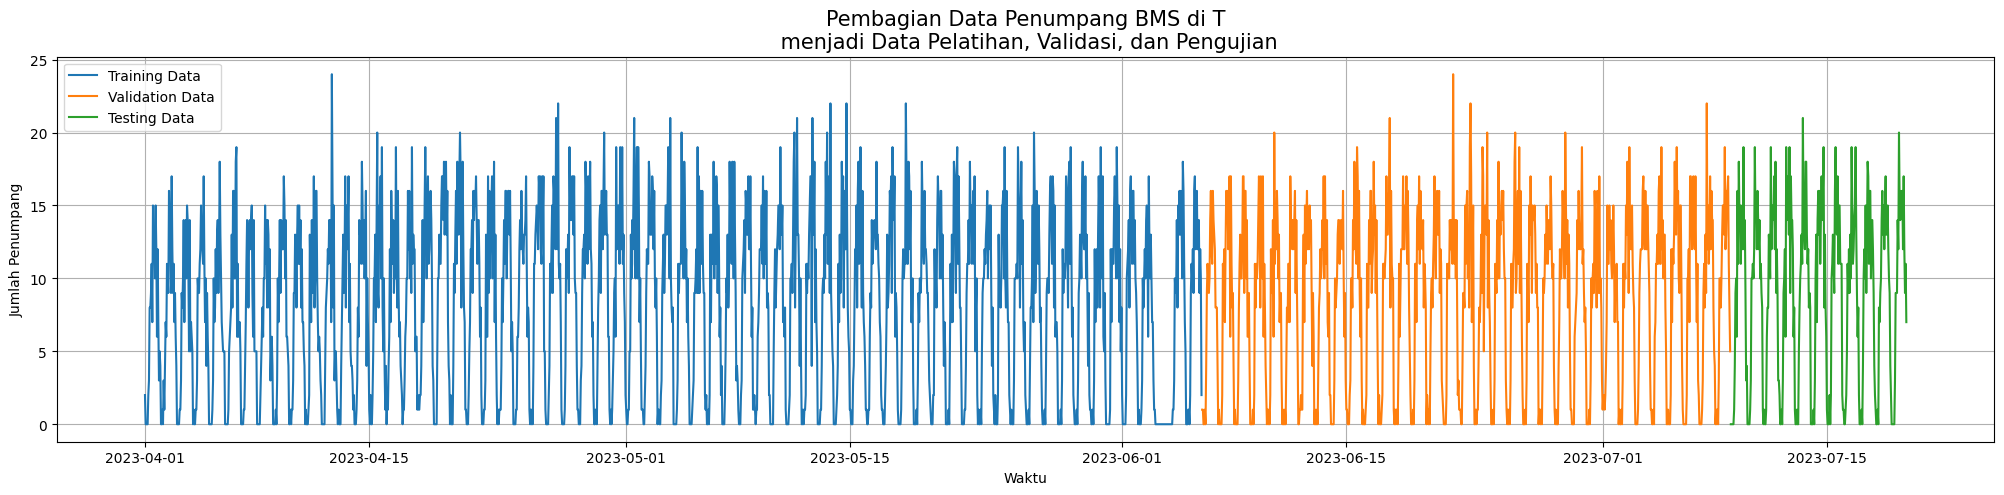

In [15]:
plt.subplots(figsize=(25, 5))
sns.lineplot(x="DATE", y="ARRIVAL",
             data=data_train, label='Training Data')
sns.lineplot(x="DATE", y="ARRIVAL",
             data=data_val, label='Validation Data')
sns.lineplot(x="DATE", y="ARRIVAL",
             data=data_test, label='Testing Data')
plt.xlabel('Waktu'); plt.ylabel('Jumlah Penumpang')
plt.title("Pembagian Data Penumpang BMS di T\n menjadi Data Pelatihan, Validasi, dan Pengujian", fontsize = 15)
plt.grid()
plt.legend(loc='upper left')

## check sequence data

In [16]:
print(data_train.to_string())

                                   DATE  PAX_BMS_T3  ARRIVAL
DATE                                                        
2023-04-01 00:00:00 2023-04-01 00:00:00           0        2
2023-04-01 01:00:00 2023-04-01 01:00:00           0        0
2023-04-01 02:00:00 2023-04-01 02:00:00           0        0
2023-04-01 03:00:00 2023-04-01 03:00:00           0        0
2023-04-01 04:00:00 2023-04-01 04:00:00           0        0
2023-04-01 05:00:00 2023-04-01 05:00:00           0        2
2023-04-01 06:00:00 2023-04-01 06:00:00          11        3
2023-04-01 07:00:00 2023-04-01 07:00:00          53        8
2023-04-01 08:00:00 2023-04-01 08:00:00          51        8
2023-04-01 09:00:00 2023-04-01 09:00:00          81        9
2023-04-01 10:00:00 2023-04-01 10:00:00          61       11
2023-04-01 11:00:00 2023-04-01 11:00:00          93        7
2023-04-01 12:00:00 2023-04-01 12:00:00          59       15
2023-04-01 13:00:00 2023-04-01 13:00:00         104       12
2023-04-01 14:00:00 2023

In [17]:
paxT3 = data["PAX_BMS_T3"].values.reshape(-1, 1)

paxT3_train = data_train["PAX_BMS_T3"].values.reshape(-1, 1)

paxT3_val = data_val["PAX_BMS_T3"].values.reshape(-1, 1)

paxT3_test = data_test["PAX_BMS_T3"].values.reshape(-1, 1)

print(paxT3_train.shape);print(paxT3_val.shape)

(1584, 1)
(792, 1)


In [18]:
arrivalT3 = data["ARRIVAL"].values.reshape(-1, 1)

arrivalT3_train = data_train["ARRIVAL"].values.reshape(-1, 1)

arrivalT3_val = data_val["ARRIVAL"].values.reshape(-1, 1)

arrivalT3_test = data_test["ARRIVAL"].values.reshape(-1, 1)

print(arrivalT3_train.shape);print(arrivalT3_val.shape)

(1584, 1)
(792, 1)


In [19]:
x_train = []
y_train = []

for i in range(n_lookback, len(paxT3_train) + 1):
    x_train.append(paxT3_train[i - n_lookback: i])
    y_train.append(arrivalT3_train[i - n_lookback: i])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1561, 24, 1)
(1561, 24, 1)


In [20]:
print(y_train[0])

[[ 2]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 2]
 [ 3]
 [ 8]
 [ 8]
 [ 9]
 [11]
 [ 7]
 [15]
 [12]
 [13]
 [10]
 [15]
 [12]
 [ 6]
 [12]
 [ 7]
 [ 3]
 [ 5]
 [ 4]]


In [21]:
x_val = []
y_val = []

for i in range(n_lookback, len(paxT3_val) + 1):
    x_val.append(paxT3_val[i - n_lookback: i])
    y_val.append(arrivalT3_val[i - n_lookback: i])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(769, 24, 1)
(769, 24, 1)


In [22]:
print(x_val[-1]);print(y_val[-1])

[[  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 15]
 [ 37]
 [ 78]
 [ 87]
 [123]
 [113]
 [116]
 [132]
 [105]
 [120]
 [173]
 [ 95]
 [ 91]
 [ 88]
 [ 65]
 [ 99]
 [ 34]
 [  0]]
[[ 4]
 [ 0]
 [ 1]
 [ 0]
 [ 1]
 [ 0]
 [ 3]
 [10]
 [10]
 [ 8]
 [10]
 [13]
 [15]
 [15]
 [13]
 [19]
 [12]
 [13]
 [16]
 [16]
 [17]
 [11]
 [ 8]
 [ 5]]


# Scaling / Normalize Data

In [23]:
paxT3_train_scaled = normalize_series(paxT3_train, Average(paxT3_train), stdev(convert_bit_lenght(paxT3_train)))
paxT3_val_scaled = normalize_series(paxT3_val, Average(paxT3_val), stdev(convert_bit_lenght(paxT3_val)))
paxT3_test_scaled = normalize_series(paxT3_test, Average(paxT3_test), stdev(convert_bit_lenght(paxT3_test)))

arrivalT3_train_scaled = normalize_series(arrivalT3_train, Average(arrivalT3_train), stdev(convert_bit_lenght(arrivalT3_train)))
arrivalT3_val_scaled = normalize_series(arrivalT3_val, Average(arrivalT3_val), stdev(convert_bit_lenght(arrivalT3_val)))
arrivalT3_test_scaled = normalize_series(arrivalT3_test, Average(arrivalT3_test), stdev(convert_bit_lenght(arrivalT3_test)))

## Set feature and label period

In [24]:
x_train = []
y_train = []

for i in range(n_lookback, len(paxT3_train_scaled) + 1):
    x_train.append(arrivalT3_train_scaled[i - n_lookback: i])
    y_train.append(paxT3_train_scaled[i - n_lookback: i])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1561, 24, 1)
(1561, 24, 1)


In [25]:
x_val = []
y_val = []

for i in range(n_lookback, len(paxT3_val_scaled) + 1):
    x_val.append(arrivalT3_val_scaled[i - n_lookback: i])
    y_val.append(paxT3_val_scaled[i - n_lookback: i])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(769, 24, 1)
(769, 24, 1)


# Vanilla GRU

## generate model

In [45]:
modelVanillaGRU = Sequential([
        GRU(7, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', return_sequences=True,
            input_shape=x_train[0].shape),                                          
        Flatten(),
        Dense(n_forecast)
    ])

modelVanillaGRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 24, 7)             210       
                                                                 
 flatten_2 (Flatten)         (None, 168)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                4056      
                                                                 
Total params: 4,266
Trainable params: 4,266
Non-trainable params: 0
_________________________________________________________________


In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
modelVanillaGRU.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mse"])

In [47]:
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,verbose=1,
                                       restore_best_weights=True)
mc=tf.keras.callbacks.ModelCheckpoint('./model v1/VanillaGRU-Model.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

In [48]:
historyVanillaGRU = modelVanillaGRU.fit(
    x_train, y_train, 
    epochs=1000, 
    batch_size=16, 
    callbacks=[estop, mc],
    validation_data=(x_val,y_val))

Epoch 1/1000
90/98 [==========================>...] - ETA: 0s - loss: 306.1089 - mse: 306.0187
Epoch 1: val_mse improved from inf to 279.82007, saving model to ./model v1\VanillaGRU-Model.h5
98/98 [==============================] - 2s 8ms/step - loss: 305.1327 - mse: 305.0425 - val_loss: 279.9101 - val_mse: 279.8201
Epoch 2/1000
92/98 [===========================>..] - ETA: 0s - loss: 301.7729 - mse: 301.6829
Epoch 2: val_mse improved from 279.82007 to 276.53558, saving model to ./model v1\VanillaGRU-Model.h5
98/98 [==============================] - 1s 6ms/step - loss: 302.0019 - mse: 301.9119 - val_loss: 276.6255 - val_mse: 276.5356
Epoch 3/1000
90/98 [==========================>...] - ETA: 0s - loss: 299.5835 - mse: 299.4937
Epoch 3: val_mse improved from 276.53558 to 273.05902, saving model to ./model v1\VanillaGRU-Model.h5
98/98 [==============================] - 1s 6ms/step - loss: 298.7294 - mse: 298.6396 - val_loss: 273.1487 - val_mse: 273.0590
Epoch 4/1000
96/98 [==============

In [51]:
with open('./model v1/historyVanillaGRU', 'wb') as file_pi:
    pickle.dump(historyVanillaGRU.history, file_pi)

with open('./model v1/historyVanillaGRU', "rb") as file_pi:
    load_historyVanillaGRU = pickle.load(file_pi)

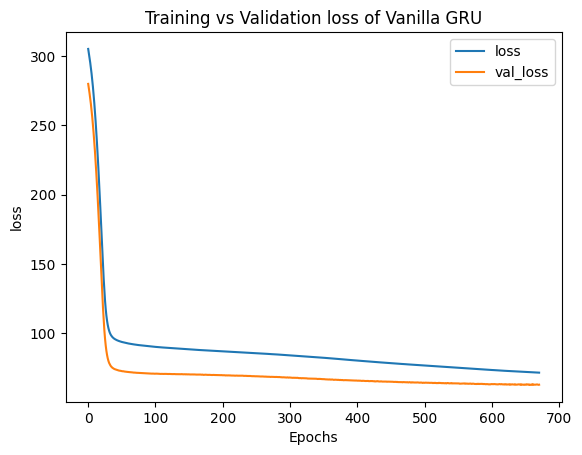

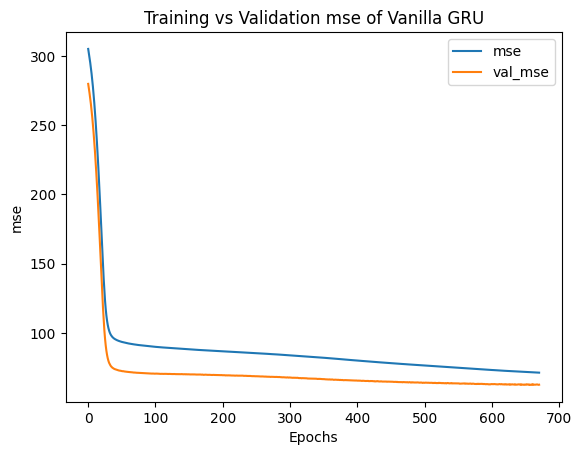

In [52]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of Vanilla GRU")
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyVanillaGRU, "loss")
plot_graphs(historyVanillaGRU, "mse")

## Prediction

### Prediction with training data

In [53]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [54]:
forecast_train_data = model_forecast(modelVanillaGRU, arrivalT3_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(paxT3_train_scaled.shape[0]-n_lookback)

1561/1561 [==============================] - 2s 1ms/step
(1561, 24)
(1560,)
1560


In [55]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(paxT3_train), stdev(convert_bit_lenght(paxT3_train)))
forecast_train_data[:5]

array([-10.98807903,  -7.34852978,  -8.43386455,   3.03300098,
         9.92205051])

In [56]:
actual = np.squeeze(paxT3_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1560,)
[0 0 0 0 0]


In [57]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2023-04-02 00:00:00       0 -10.988079
1    2023-04-02 01:00:00       0  -7.348530
2    2023-04-02 02:00:00       0  -8.433865
3    2023-04-02 03:00:00       0   3.033001
4    2023-04-02 04:00:00       0   9.922051
...                  ...     ...        ...
1555 2023-06-05 19:00:00      52  90.985050
1556 2023-06-05 20:00:00      81  89.780945
1557 2023-06-05 21:00:00      64  63.513921
1558 2023-06-05 22:00:00      46  34.861542
1559 2023-06-05 23:00:00      12  18.877922

[1560 rows x 3 columns]

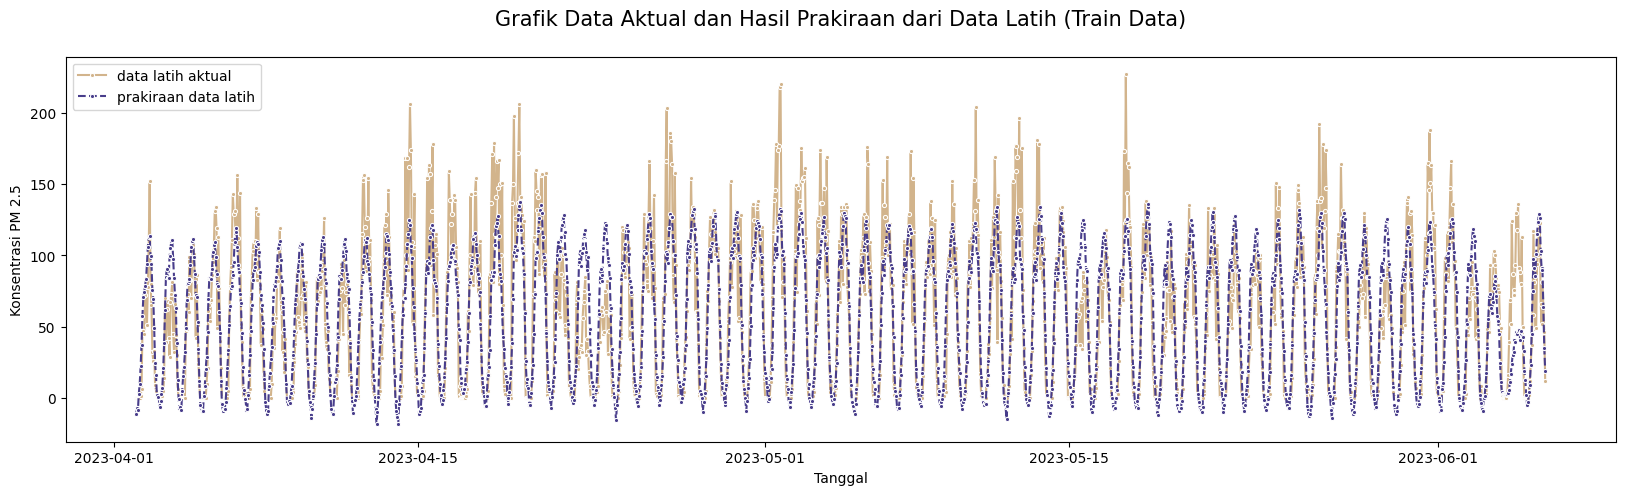

In [58]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [117]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  27.32
MAE:  18.54
MAPE:  0.6508


### Prediction with validation data

In [118]:
forecast_val_data = model_forecast(modelVanillaGRU, arrivalT3_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(paxT3_val_scaled.shape[0]-n_lookback)

      1/Unknown - 0s 22ms/step

769/769 [==============================] - 1s 1ms/step
(769, 24)
(768,)
768


In [119]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(paxT3_val), stdev(convert_bit_lenght(paxT3_val)))
forecast_val_data[:5]

array([-2.35907194,  1.05457094,  5.54221514,  3.15668276, -3.49569151])

In [120]:
actual = np.squeeze(paxT3_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(768,)
[0 0 0 0 0]


In [121]:
len(data_val[-forecast_val_data.shape[0]:])

768

In [122]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2023-06-07 00:00:00       0  -2.359072
1   2023-06-07 01:00:00       0   1.054571
2   2023-06-07 02:00:00       0   5.542215
3   2023-06-07 03:00:00       0   3.156683
4   2023-06-07 04:00:00       0  -3.495692
..                  ...     ...        ...
763 2023-07-08 19:00:00      88  99.848039
764 2023-07-08 20:00:00      65  90.395059
765 2023-07-08 21:00:00      99  73.303720
766 2023-07-08 22:00:00      34  45.538384
767 2023-07-08 23:00:00       0  20.782934

[768 rows x 3 columns]

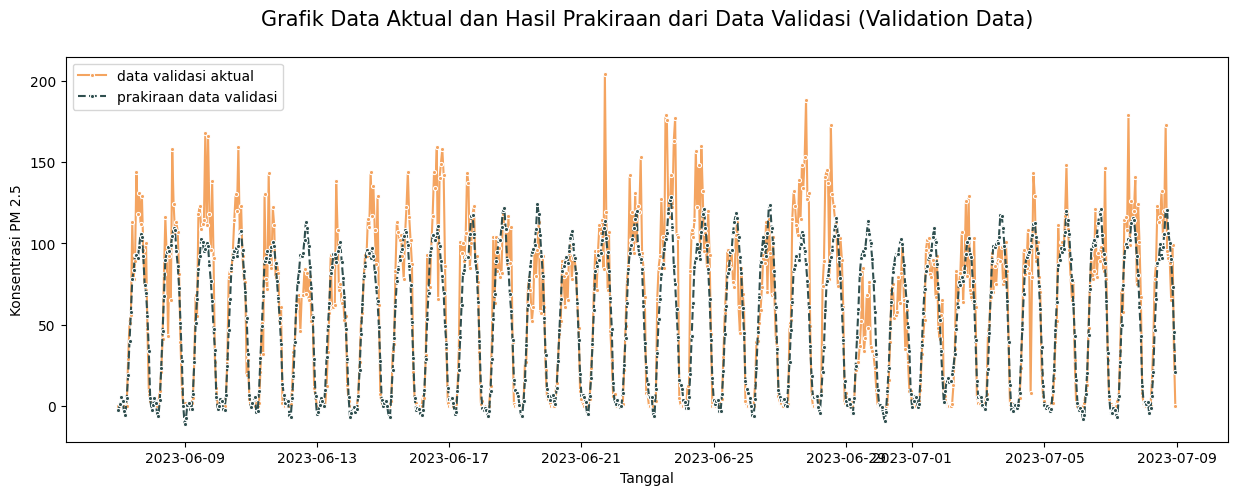

In [123]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [124]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  23.77
MAE:  16.15
MAPE:  0.571


### Prediction with test data

In [125]:
forecast_test_data = model_forecast(modelVanillaGRU, arrivalT3_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(paxT3_test_scaled.shape[0]-n_lookback)

      1/Unknown - 0s 22ms/step

241/241 [==============================] - 0s 1ms/step
(241, 24)
(240,)
240


In [126]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(paxT3_test), stdev(convert_bit_lenght(paxT3_test)))
forecast_test_data[:5]

array([ 1.73747959,  5.64872302,  2.02794589, -1.25087414, -6.91999112])

In [127]:
actual = np.squeeze(paxT3_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(240,)
[1 0 0 0 0]


In [128]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0   2023-07-10 00:00:00       1   1.737480
1   2023-07-10 01:00:00       0   5.648723
2   2023-07-10 02:00:00       0   2.027946
3   2023-07-10 03:00:00       0  -1.250874
4   2023-07-10 04:00:00       0  -6.919991
..                  ...     ...        ...
235 2023-07-19 19:00:00      65  87.840190
236 2023-07-19 20:00:00      90  79.233394
237 2023-07-19 21:00:00      47  59.957423
238 2023-07-19 22:00:00      31  35.292573
239 2023-07-19 23:00:00       4  11.418800

[240 rows x 3 columns]

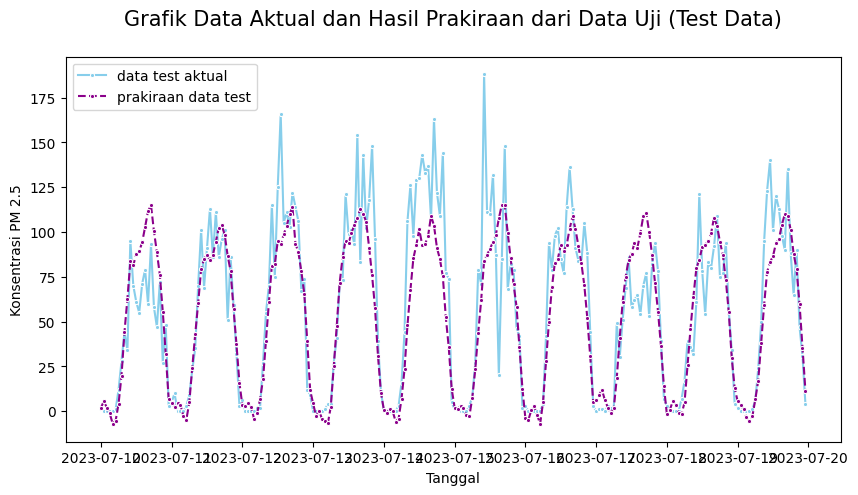

In [129]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [130]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  23.14
MAE:  15.88
MAPE:  0.5591


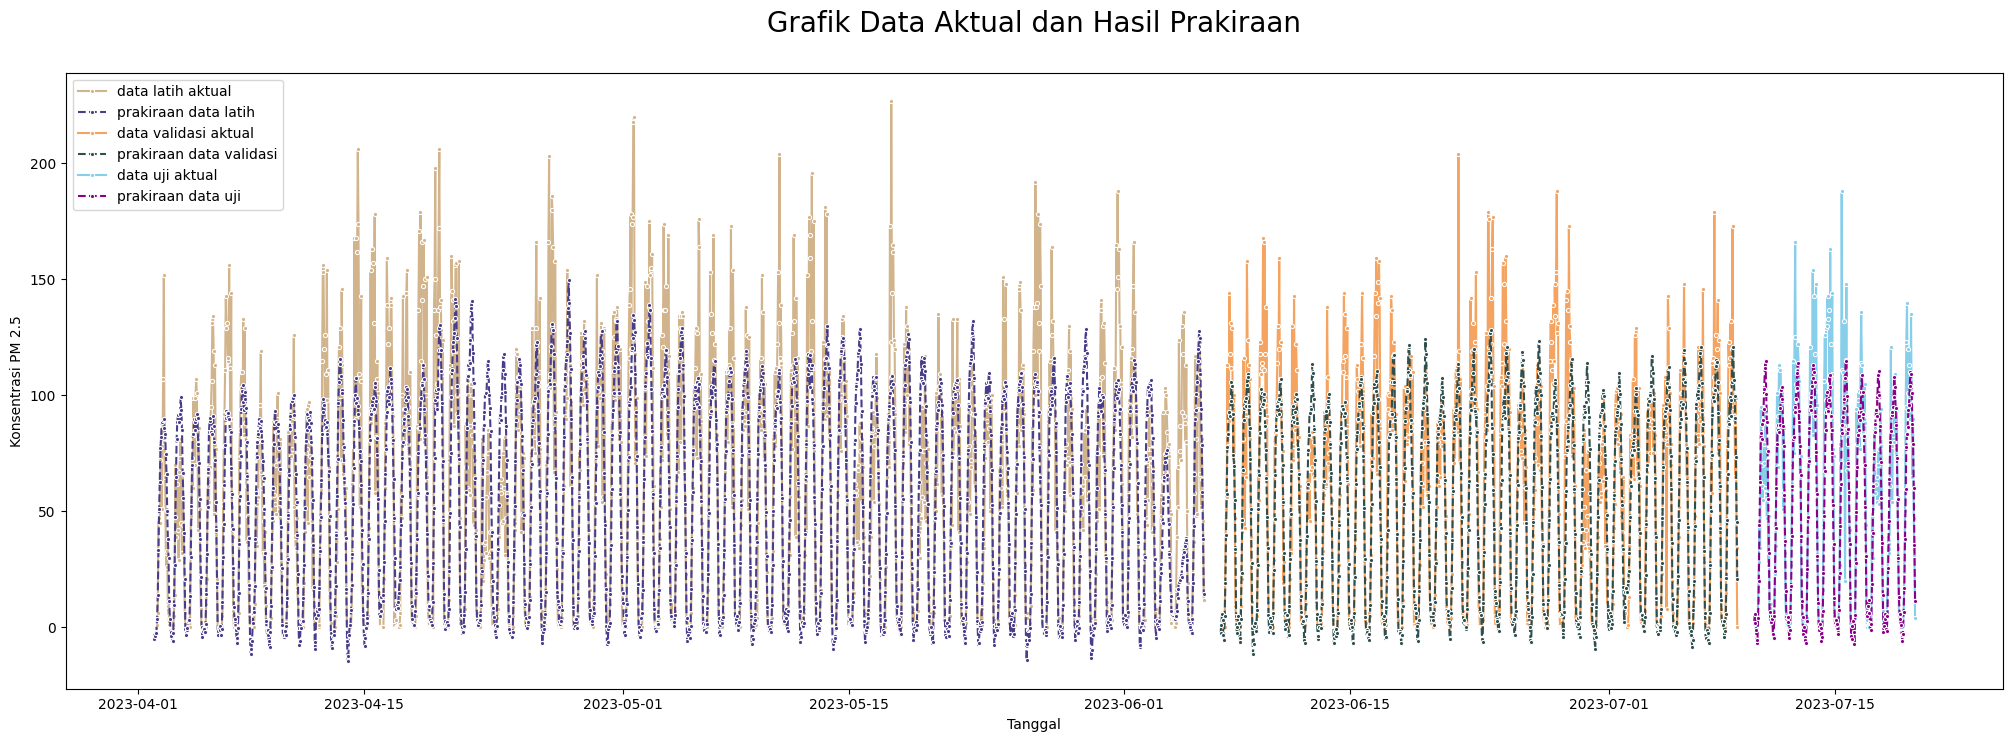

In [131]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

# Bidirectional GRU

## generate model

In [132]:
modelBidirectionalGRU = Sequential([
        GRU(16, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', return_sequences=True,
            input_shape=x_train[0].shape),                                          
        Flatten(),
        Dense(n_forecast)
    ])

modelBidirectionalGRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 24, 16)            912       
                                                                 
 flatten_3 (Flatten)         (None, 384)               0         
                                                                 
 dense_3 (Dense)             (None, 24)                9240      
                                                                 
Total params: 10,152
Trainable params: 10,152
Non-trainable params: 0
_________________________________________________________________


In [133]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
modelBidirectionalGRU.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

In [134]:
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,verbose=1,
                                       restore_best_weights=True)
mc=tf.keras.callbacks.ModelCheckpoint('./model v1/BidirectionalGRU-Model.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

In [135]:
historyBidirectionalGRU = modelBidirectionalGRU.fit(
    x_train, y_train, 
    epochs=1000, 
    batch_size=8, 
    callbacks=[estop, mc],
    validation_data=(x_val,y_val))

Epoch 1/1000


191/196 [============================>.] - ETA: 0s - loss: 14.7509 - mse: 304.9774
Epoch 1: val_mse improved from inf to 277.87433, saving model to ./model v1\BidirectionalGRU-Model.h5
196/196 [==============================] - 2s 6ms/step - loss: 14.7554 - mse: 305.1385 - val_loss: 14.3358 - val_mse: 277.8743
Epoch 2/1000
192/196 [============================>.] - ETA: 0s - loss: 14.5050 - mse: 296.0718
Epoch 2: val_mse improved from 277.87433 to 268.50018, saving model to ./model v1\BidirectionalGRU-Model.h5
196/196 [==============================] - 1s 6ms/step - loss: 14.5121 - mse: 296.3090 - val_loss: 14.0565 - val_mse: 268.5002
Epoch 3/1000
189/196 [===========================>..] - ETA: 0s - loss: 14.2081 - mse: 285.2822
Epoch 3: val_mse improved from 268.50018 to 256.54764, saving model to ./model v1\BidirectionalGRU-Model.h5
196/196 [==============================] - 1s 6ms/step - loss: 14.2094 - mse: 285.4240 - val_loss: 13.6963 - val_mse: 256.5476
Epoch 4/1000
192/196 [====

In [136]:
with open('./model v1/historyBidirectionalGRU', 'wb') as file_pi:
    pickle.dump(historyBidirectionalGRU.history, file_pi)

with open('./model v1/historyBidirectionalGRU', "rb") as file_pi:
    load_historyBidirectionalGRU = pickle.load(file_pi)

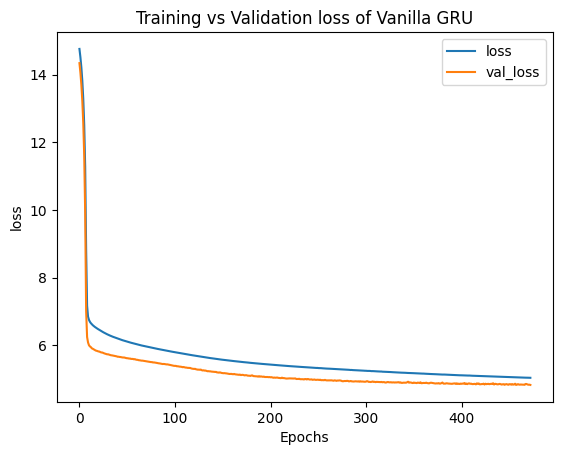

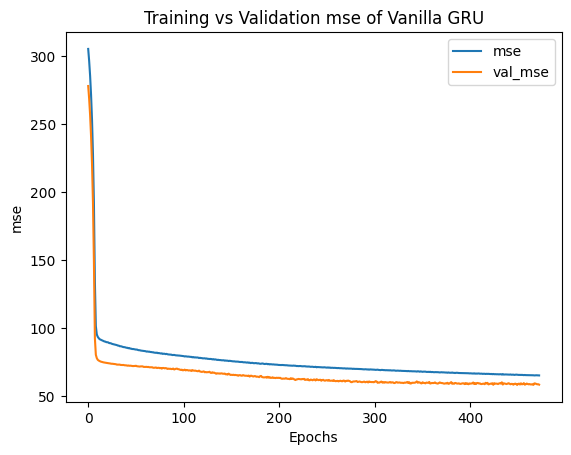

In [137]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of Vanilla GRU")
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyBidirectionalGRU, "loss")
plot_graphs(historyBidirectionalGRU, "mse")

## Prediction

### Prediction with training data

In [138]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [159]:
forecast_train_data = model_forecast(modelBidirectionalGRU, arrivalT3_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(paxT3_train_scaled.shape[0]-n_lookback)

      1/Unknown - 0s 23ms/step

1561/1561 [==============================] - 3s 2ms/step
(1561, 24)
(1560,)
1560


In [160]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(paxT3_train), stdev(convert_bit_lenght(paxT3_train)))
forecast_train_data[:5]

array([ 1.13993076, -1.41862865, -0.73786159,  1.94315342, -3.38743969])

In [161]:
actual = np.squeeze(paxT3_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1560,)
[0 0 0 0 0]


In [162]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2023-04-02 00:00:00       0   1.139931
1    2023-04-02 01:00:00       0  -1.418629
2    2023-04-02 02:00:00       0  -0.737862
3    2023-04-02 03:00:00       0   1.943153
4    2023-04-02 04:00:00       0  -3.387440
...                  ...     ...        ...
1555 2023-06-05 19:00:00      52  92.646217
1556 2023-06-05 20:00:00      81  80.207195
1557 2023-06-05 21:00:00      64  54.994989
1558 2023-06-05 22:00:00      46  38.145086
1559 2023-06-05 23:00:00      12  14.720539

[1560 rows x 3 columns]

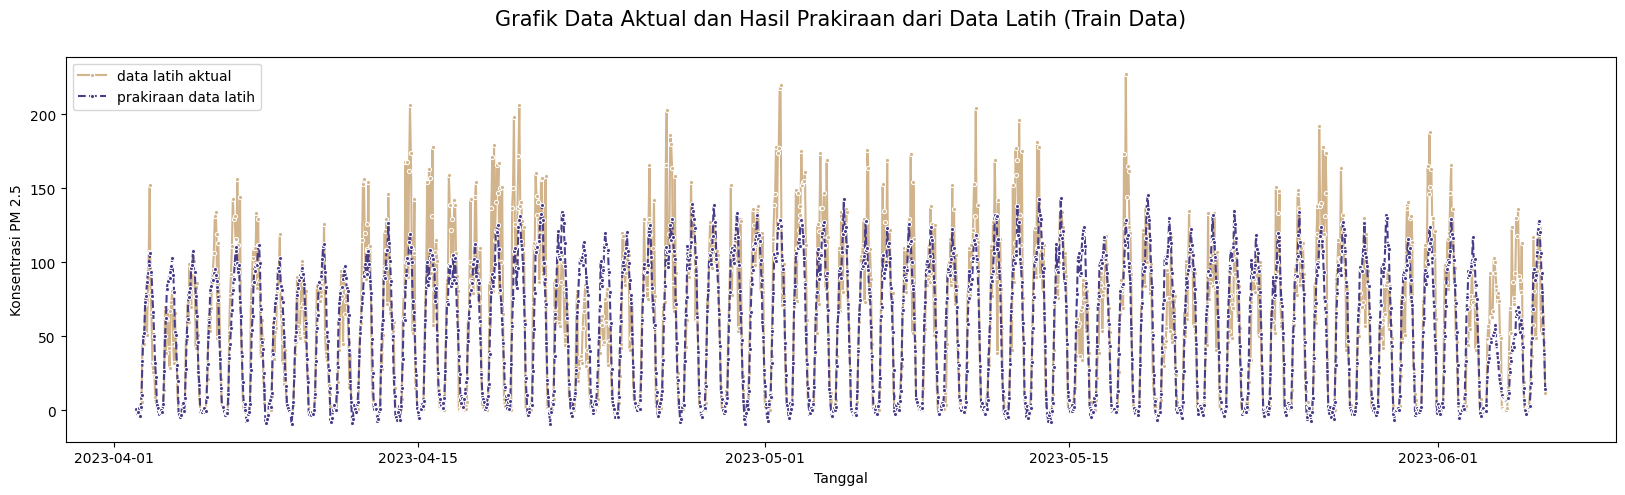

In [163]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [164]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  25.57
MAE:  17.22
MAPE:  0.6861


## Prediction with validation data

In [170]:
forecast_val_data = model_forecast(modelBidirectionalGRU, arrivalT3_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(paxT3_val_scaled.shape[0]-n_lookback)

      1/Unknown - 0s 23ms/step

769/769 [==============================] - 1s 2ms/step
(769, 24)
(768,)
768


In [171]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(paxT3_val), stdev(convert_bit_lenght(paxT3_val)))
forecast_val_data[:5]

array([-0.21856901,  0.65947511,  1.70290926,  0.09120729, -2.81354735])

In [172]:
actual = np.squeeze(paxT3_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(768,)
[0 0 0 0 0]


In [173]:
len(data_val[-forecast_val_data.shape[0]:])

768

In [174]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual    Forecast
0   2023-06-07 00:00:00       0   -0.218569
1   2023-06-07 01:00:00       0    0.659475
2   2023-06-07 02:00:00       0    1.702909
3   2023-06-07 03:00:00       0    0.091207
4   2023-06-07 04:00:00       0   -2.813547
..                  ...     ...         ...
763 2023-07-08 19:00:00      88  102.173494
764 2023-07-08 20:00:00      65   94.366659
765 2023-07-08 21:00:00      99   80.538540
766 2023-07-08 22:00:00      34   51.712155
767 2023-07-08 23:00:00       0   28.713173

[768 rows x 3 columns]

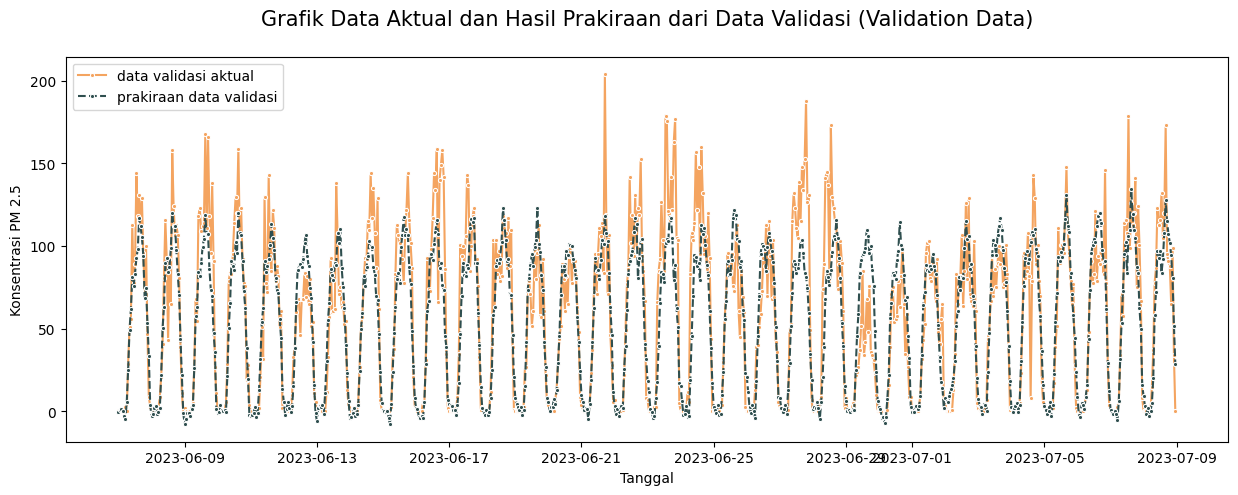

In [175]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [176]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  23.05
MAE:  15.54
MAPE:  0.6444


## Prediction with test data

In [177]:
forecast_test_data = model_forecast(modelBidirectionalGRU, arrivalT3_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(paxT3_test_scaled.shape[0]-n_lookback)

      1/Unknown - 0s 27ms/step

241/241 [==============================] - 1s 2ms/step
(241, 24)
(240,)
240


In [178]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(paxT3_test), stdev(convert_bit_lenght(paxT3_test)))
forecast_test_data[:5]

array([3.46054782, 4.22933521, 1.87232913, 2.72366657, 0.9147829 ])

In [179]:
actual = np.squeeze(paxT3_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(240,)
[1 0 0 0 0]


In [180]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0   2023-07-10 00:00:00       1   3.460548
1   2023-07-10 01:00:00       0   4.229335
2   2023-07-10 02:00:00       0   1.872329
3   2023-07-10 03:00:00       0   2.723667
4   2023-07-10 04:00:00       0   0.914783
..                  ...     ...        ...
235 2023-07-19 19:00:00      65  83.379014
236 2023-07-19 20:00:00      90  80.465057
237 2023-07-19 21:00:00      47  57.634089
238 2023-07-19 22:00:00      31  35.657903
239 2023-07-19 23:00:00       4  15.756389

[240 rows x 3 columns]

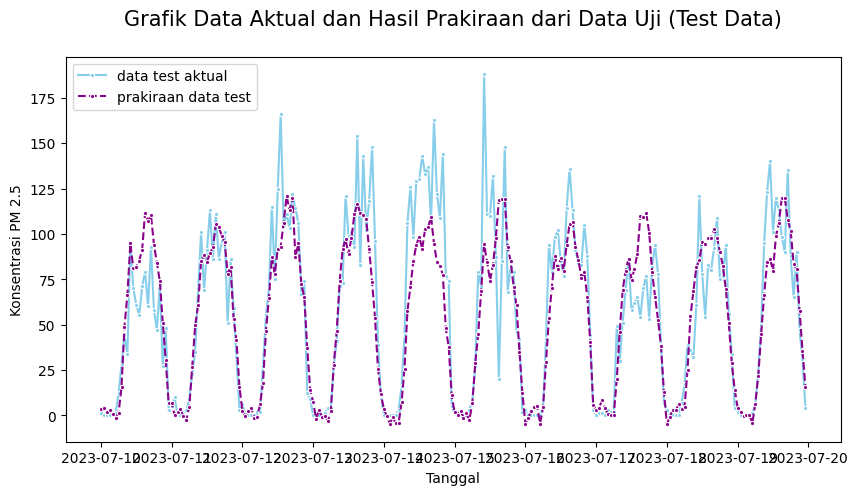

In [181]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [182]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  22.75
MAE:  15.34
MAPE:  1.6703


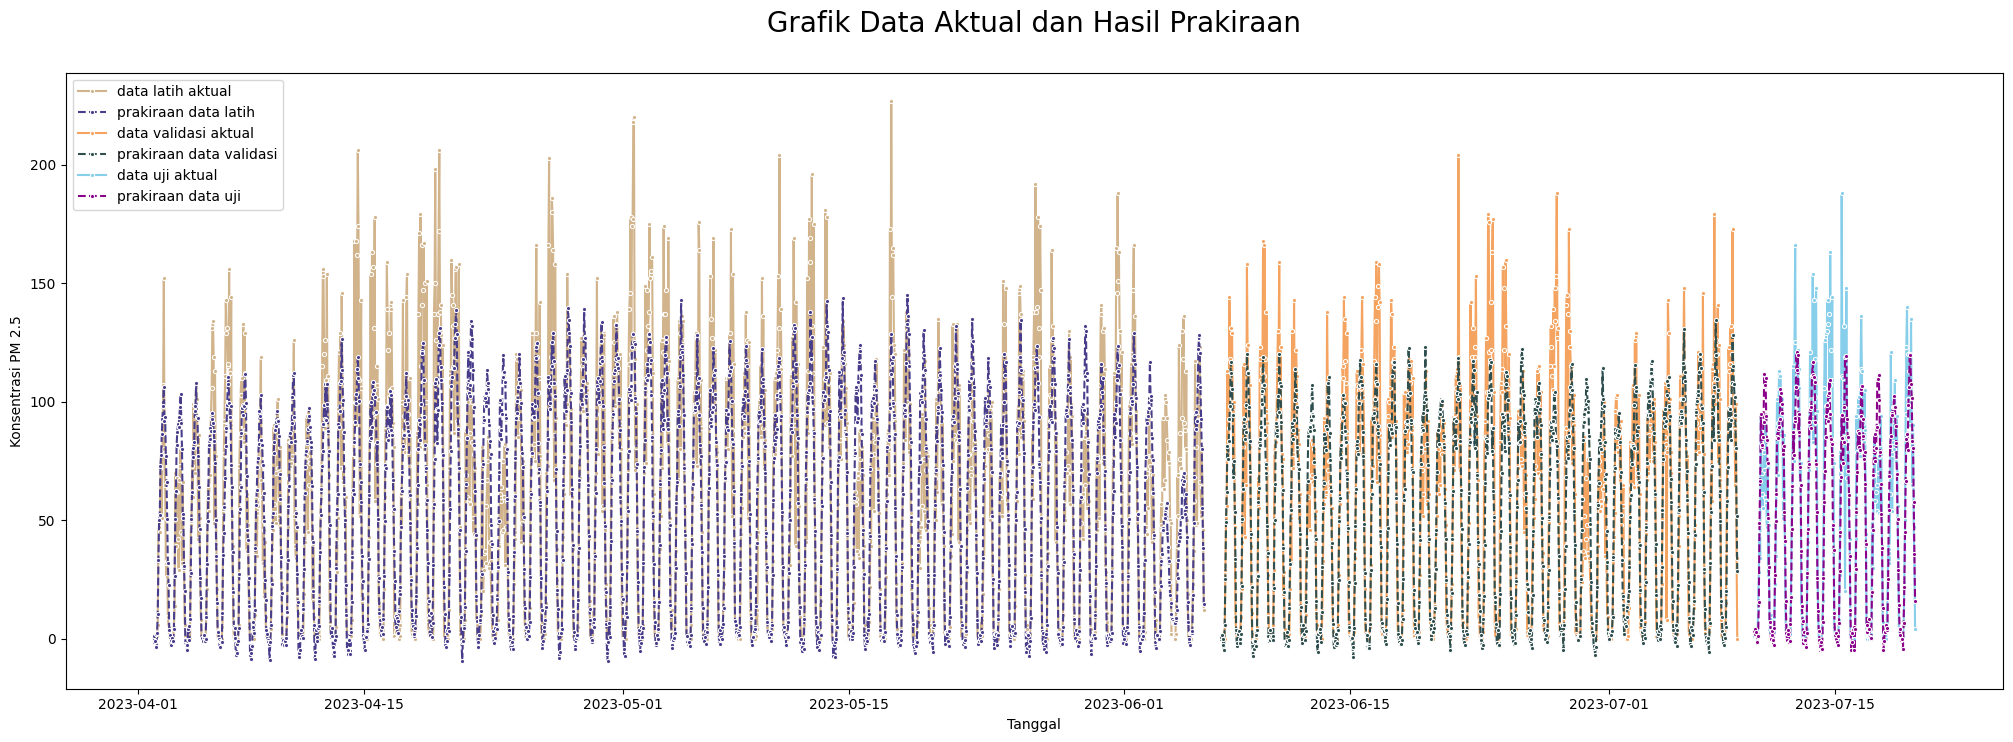

In [183]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')